# Overview

This notebook is my workspace in participation for Datafest 2024 held by American Statistical Association at UW.

Due to the time constraint, the code may be a bit out of order, and many of the notations in here were added after the competition.

One thing worth mentioning is that our group was awarded with the *Best Visualization Award*.

This notebook contains only my work with unsupervised learning. For more work by our team members as a whole, please check the other documents on github.

**Competition Content:**

We were provided a few raw datasets from CourseKata, a statistical learning platform, with the performance of the students using this platform. The data included student's self ratings on various aspects, time spent on the pages across different chapters and books, retry attempts, time the student did not interact with the platform, and the EOC, which is some score the student gets after completing the checkpoints.

Our goal was to analyze the student behaviors and provide insights and recommendations to CourseKata, which aims to improve their understandings of how to help students maximize their potential.

# Imports

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
page = pd.read_csv('/content/drive/MyDrive/UW/datafest/sample/page_views.csv')

<ipython-input-3-7ae6fb149dc8>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  page = pd.read_csv('/content/drive/MyDrive/UW/datafest/sample/page_views.csv')


In [4]:
# look at data
page

,book,release,chapter,page,chapter_number,section_number,institution_id,class_id,student_id,dt_accessed,was_complete,tried_again_dt,tried_again_clicks,engaged,idle_brief,idle_long,off_page_brief,off_page_long,review_flag
0,College / Statistics and Data Science (ABC),v5.0,Chapter 1 - Welcome to Statistics: A Modeling ...,1.3 Doing Statistics with R,1.0,3.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,2023-01-06T00:47:06Z,False,NaN,0,10857.0,0.0,0.0,0.0,0.0,False
1,College / Statistics and Data Science (ABC),v5.0,Chapter 1 - Welcome to Statistics: A Modeling ...,1.3 Doing Statistics with R,1.0,3.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,2023-01-14T04:41:55Z,False,NaN,0,620302.0,188748.0,0.0,0.0,0.0,False
2,College / Statistics and Data Science (ABC),v5.0,Chapter 1 - Welcome to Statistics: A Modeling ...,1.3 Doing Statistics with R,1.0,3.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,2023-01-14T20:15:03Z,True,NaN,0,793964.0,0.0,0.0,0.0,0.0,False
3,College / Statistics and Data Science (ABC),v5.0,Chapter 1 - Welcome to Statistics: A Modeling ...,1.4 Introduction to R Functions,1.0,4.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,2023-01-06T00:46:58Z,False,NaN,0,6250.0,0.0,0.0,0.0,0.0,False
4,College / Statistics and Data Science (ABC),v5.0,Chapter 1 - Welcome to Statistics: A Modeling ...,1.4 Introduction to R Functions,1.0,4.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,2023-01-14T23:51:24Z,True,NaN,0,30885.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73104,High School / Advanced Statistics and Data Sci...,v5.0,Getting Started (Don't Skip This Part),First Things First! (Don't Skip This Page),NaN,NaN,fc5f1b1b-2aeb-4e09-93fc-06fdac0d8030,95370fbf-5008-435f-b801-8214285f251b,358dde6e-b5ae-4fa4-898e-05cfff311129,2023-01-31T22:44:29Z,False,NaN,0,212398.0,0.0,0.0,0.0,0.0,False
73105,High School / Advanced Statistics and Data Sci...,v5.0,Getting Started (Don't Skip This Part),First Things First! (Don't Skip This Page),NaN,NaN,fc5f1b1b-2aeb-4e09-93fc-06fdac0d8030,95370fbf-5008-435f-b801-8214285f251b,358dde6e-b5ae-4fa4-898e-05cfff311129,2023-01-31T22:48:09Z,True,NaN,0,6511.0,0.0,0.0,0.0,0.0,False
73106,High School / Advanced Statistics and Data Sci...,v5.0,Getting Started (Don't Skip This Part),Student Survey (REQUIRED),NaN,NaN,fc5f1b1b-2aeb-4e09-93fc-06fdac0d8030,95370fbf-5008-435f-b801-8214285f251b,358dde6e-b5ae-4fa4-898e-05cfff311129,2023-01-31T22:38:28Z,False,NaN,0,295702.0,0.0,0.0,0.0,0.0,False
73107,High School / Advanced Statistics and Data Sci...,v5.0,Getting Started (Don't Skip This Part),Student Survey (REQUIRED),NaN,NaN,fc5f1b1b-2aeb-4e09-93fc-06fdac0d8030,95370fbf-5008-435f-b801-8214285f251b,358dde6e-b5ae-4fa4-898e-05cfff311129,2023-01-31T22:48:17Z,True,NaN,0,2201.0,0.0,0.0,0.0,0.0,False


# Data Process

After examining the data closely, we decided to look more closely at the chapters in books that were especially hard. This easy/hard level was measured by students EOC, which is some estimate of correctness on the checkpoints. If the EOC for students were generally low for specific chapters, we considered those chapters as harder chapters.

The visualization for this comparison is on github.

In [95]:
ABC13_group = page[(page['book'] == 'College / Statistics and Data Science (ABC)') & (page['chapter_number'] == 13) | (page['chapter_number'] == 11)].groupby(['student_id', 'chapter_number', 'book'], as_index=False).agg({'engaged': 'sum', 'was_complete': 'mean', 'tried_again_clicks': 'mean', 'idle_brief': 'mean', 'idle_long': 'mean', 'off_page_brief': 'mean', 'off_page_long': 'mean'})

In [96]:
ABC13_group

,student_id,chapter_number,book,engaged,was_complete,tried_again_clicks,idle_brief,idle_long,off_page_brief,off_page_long
0,001824fb-a2fd-431d-aef6-7a1250d97a62,11,College / Statistics and Data Science (ABC),10808091.0,0.5,0.0,4.172925e+04,0.000000,336636.285714,9.995588e+06
1,041a771b-41cc-4b36-928d-ec321f918db5,11,College / Advanced Statistics and Data Science...,7935012.0,0.153846,0.0,1.233224e+05,0.000000,198189.384615,0.000000e+00
2,04347fe5-e55a-4adc-86f2-a156ddfcfc13,11,College / Advanced Statistics and Data Science...,14030032.0,0.652174,0.0,8.845189e+04,0.000000,85956.673913,6.720893e+05
3,045d0e87-585c-4126-a2c0-c744effb11b2,11,College / Advanced Statistics and Data Science...,8527048.0,0.0625,0.0,5.420478e+05,114072.300000,123183.400000,1.615603e+06
4,05588964-8577-4b9f-9a5e-ddb770184d3c,11,College / Advanced Statistics and Data Science...,5095533.0,0.461538,0.0,7.935067e+04,788112.047619,124722.619048,1.838338e+06
...,...,...,...,...,...,...,...,...,...,...
213,fcdfb64b-0dd7-4839-a76d-1bd3d688d5c0,13,College / Statistics and Data Science (ABC),2834458.0,0.117647,0.0,2.990050e+04,111009.625000,4584.937500,0.000000e+00
214,fd2a1c41-0bc1-47c6-8ab3-d238a9a648ef,11,College / Statistics and Data Science (ABC),3900910.0,0.0,0.0,1.949084e+05,112584.454545,274429.909091,1.100894e+06
215,fdc4706b-6963-41e4-9a96-ce7b44b2dc46,11,College / Statistics and Data Science (ABC),2025658.0,0.0,0.0,1.299757e+05,461593.727273,99980.909091,1.725092e+06
216,fdc4706b-6963-41e4-9a96-ce7b44b2dc46,13,College / Statistics and Data Science (ABC),987351.0,0.0,0.0,1.342110e+06,0.000000,884324.000000,1.836877e+07


Group the data by unique student id, chapter number, and book, since there can be multiple parts in a chapter, making it hard for analysis. The other features are aggregated using different measurements.

In [97]:
page['chapter_number'] = page['chapter_number'].fillna(-1).astype(int)
grouped_data = page.groupby(['student_id', 'chapter_number', 'book'], as_index=False).agg({'engaged': 'sum', 'was_complete': 'mean', 'tried_again_clicks': 'mean', 'idle_brief': 'mean', 'idle_long': 'mean', 'off_page_brief': 'mean', 'off_page_long': 'mean'})
grouped_data

,student_id,chapter_number,book,engaged,was_complete,tried_again_clicks,idle_brief,idle_long,off_page_brief,off_page_long
0,001824fb-a2fd-431d-aef6-7a1250d97a62,-1,College / Statistics and Data Science (ABC),4953423.0,0.459459,0.000000,27289.818182,1.363073e+05,97648.484848,1.263986e+06
1,001824fb-a2fd-431d-aef6-7a1250d97a62,1,College / Statistics and Data Science (ABC),5663330.0,0.655172,0.413793,87571.724138,0.000000e+00,240159.724138,9.939353e+05
2,001824fb-a2fd-431d-aef6-7a1250d97a62,2,College / Statistics and Data Science (ABC),30902762.0,0.375,0.000000,108307.057971,1.542070e+05,381067.695652,3.912470e+06
3,001824fb-a2fd-431d-aef6-7a1250d97a62,3,College / Statistics and Data Science (ABC),34127489.0,0.477273,0.000000,42819.860465,0.000000e+00,384164.046512,1.532114e+06
4,001824fb-a2fd-431d-aef6-7a1250d97a62,4,College / Statistics and Data Science (ABC),18987025.0,0.377778,0.000000,69897.714286,9.509102e+04,775133.523810,6.249314e+06
...,...,...,...,...,...,...,...,...,...,...
2750,fef083e8-7167-4f42-82d5-d2e893aa408a,7,College / Statistics and Data Science (ABC),11708939.0,0.387097,0.000000,142169.533333,1.719782e+05,190131.666667,3.441391e+06
2751,fef083e8-7167-4f42-82d5-d2e893aa408a,8,College / Statistics and Data Science (ABC),15435994.0,0.481481,0.000000,31535.115385,0.000000e+00,210341.076923,1.867833e+06
2752,fef083e8-7167-4f42-82d5-d2e893aa408a,9,College / Statistics and Data Science (ABC),14248225.0,0.3,0.000000,203229.266667,1.800088e+06,240931.666667,2.727550e+06
2753,fef083e8-7167-4f42-82d5-d2e893aa408a,10,College / Statistics and Data Science (ABC),3218168.0,0.333333,0.000000,26576.000000,0.000000e+00,106640.000000,4.307549e+05


Read over the dataset that contains the students EOC, and merge with the preivous dataset that contains the measurements of the student behaviors, such as time on page, number of reattempt, etc.

In [8]:
eoc=pd.read_csv('/content/drive/MyDrive/UW/datafest/sample/checkpoints_eoc.csv')

In [98]:
engage_df = pd.DataFrame(grouped_data)
merged_df = pd.merge(engage_df, eoc, on=['student_id', 'chapter_number', 'book'])

In [99]:
ABC13_merge = pd.merge(ABC13_group, eoc, on=['student_id', 'chapter_number', 'book'])

In [100]:
# this df contains only the hard chapters
ABC13_merge

,student_id,chapter_number,book,engaged,was_complete,tried_again_clicks,idle_brief,idle_long,off_page_brief,off_page_long,class_id,EOC,n_possible,n_correct,n_attempt
0,001824fb-a2fd-431d-aef6-7a1250d97a62,11,College / Statistics and Data Science (ABC),10808091.0,0.5,0.0,4.172925e+04,0.000000,336636.285714,9.995588e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.638554,83,53,107
1,041a771b-41cc-4b36-928d-ec321f918db5,11,College / Advanced Statistics and Data Science...,7935012.0,0.153846,0.0,1.233224e+05,0.000000,198189.384615,0.000000e+00,6fbf5a0a-cf5d-4567-89b5-eb5c4a16c4ab,0.367089,79,29,103
2,04347fe5-e55a-4adc-86f2-a156ddfcfc13,11,College / Advanced Statistics and Data Science...,14030032.0,0.652174,0.0,8.845189e+04,0.000000,85956.673913,6.720893e+05,6fbf5a0a-cf5d-4567-89b5-eb5c4a16c4ab,0.712329,73,52,84
3,045d0e87-585c-4126-a2c0-c744effb11b2,11,College / Advanced Statistics and Data Science...,8527048.0,0.0625,0.0,5.420478e+05,114072.300000,123183.400000,1.615603e+06,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,0.443038,79,35,97
4,05588964-8577-4b9f-9a5e-ddb770184d3c,11,College / Advanced Statistics and Data Science...,5095533.0,0.461538,0.0,7.935067e+04,788112.047619,124722.619048,1.838338e+06,6fbf5a0a-cf5d-4567-89b5-eb5c4a16c4ab,0.481013,79,38,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,fcdfb64b-0dd7-4839-a76d-1bd3d688d5c0,13,College / Statistics and Data Science (ABC),2834458.0,0.117647,0.0,2.990050e+04,111009.625000,4584.937500,0.000000e+00,cc1ffb2e-5555-4109-8ad8-2d49cb54ad10,0.678571,28,19,40
215,fd2a1c41-0bc1-47c6-8ab3-d238a9a648ef,11,College / Statistics and Data Science (ABC),3900910.0,0.0,0.0,1.949084e+05,112584.454545,274429.909091,1.100894e+06,9fad0c9e-9d3d-4eed-ada6-3959bd6d712c,0.402439,82,33,108
216,fdc4706b-6963-41e4-9a96-ce7b44b2dc46,11,College / Statistics and Data Science (ABC),2025658.0,0.0,0.0,1.299757e+05,461593.727273,99980.909091,1.725092e+06,40e49bfa-f6cb-42fa-a3a4-b23592b799ec,0.263158,57,15,66
217,fdc4706b-6963-41e4-9a96-ce7b44b2dc46,13,College / Statistics and Data Science (ABC),987351.0,0.0,0.0,1.342110e+06,0.000000,884324.000000,1.836877e+07,40e49bfa-f6cb-42fa-a3a4-b23592b799ec,0.400000,5,2,10


In [101]:
# this is the merged df for all book and chapters
merged_df

,student_id,chapter_number,book,engaged,was_complete,tried_again_clicks,idle_brief,idle_long,off_page_brief,off_page_long,class_id,EOC,n_possible,n_correct,n_attempt
0,001824fb-a2fd-431d-aef6-7a1250d97a62,1,College / Statistics and Data Science (ABC),5663330.0,0.655172,0.413793,87571.724138,0.000000e+00,240159.724138,9.939353e+05,074123e7-cd90-4500-86fe-286aaa733bf5,0.921053,38,35,40
1,001824fb-a2fd-431d-aef6-7a1250d97a62,2,College / Statistics and Data Science (ABC),30902762.0,0.375,0.000000,108307.057971,1.542070e+05,381067.695652,3.912470e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.839080,87,73,127
2,001824fb-a2fd-431d-aef6-7a1250d97a62,3,College / Statistics and Data Science (ABC),34127489.0,0.477273,0.000000,42819.860465,0.000000e+00,384164.046512,1.532114e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.769231,104,80,145
3,001824fb-a2fd-431d-aef6-7a1250d97a62,4,College / Statistics and Data Science (ABC),18987025.0,0.377778,0.000000,69897.714286,9.509102e+04,775133.523810,6.249314e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.743590,118,87,217
4,001824fb-a2fd-431d-aef6-7a1250d97a62,5,College / Statistics and Data Science (ABC),15971898.0,0.721519,0.177215,88298.121622,9.136635e+04,259799.891892,4.330305e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.777778,63,49,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,fef083e8-7167-4f42-82d5-d2e893aa408a,7,College / Statistics and Data Science (ABC),11708939.0,0.387097,0.000000,142169.533333,1.719782e+05,190131.666667,3.441391e+06,2294d558-6f5d-41c5-8d28-7b5280970f95,0.746269,67,50,81
2538,fef083e8-7167-4f42-82d5-d2e893aa408a,8,College / Statistics and Data Science (ABC),15435994.0,0.481481,0.000000,31535.115385,0.000000e+00,210341.076923,1.867833e+06,2294d558-6f5d-41c5-8d28-7b5280970f95,0.730337,89,65,150
2539,fef083e8-7167-4f42-82d5-d2e893aa408a,9,College / Statistics and Data Science (ABC),14248225.0,0.3,0.000000,203229.266667,1.800088e+06,240931.666667,2.727550e+06,2294d558-6f5d-41c5-8d28-7b5280970f95,0.675214,117,79,196
2540,fef083e8-7167-4f42-82d5-d2e893aa408a,10,College / Statistics and Data Science (ABC),3218168.0,0.333333,0.000000,26576.000000,0.000000e+00,106640.000000,4.307549e+05,2294d558-6f5d-41c5-8d28-7b5280970f95,0.363636,44,16,112


Let's check the missing values in the entire merged dataframe.

In [102]:
merged_df.isna().sum()

student_id            0
chapter_number        0
book                  0
engaged               0
was_complete          0
tried_again_clicks    0
idle_brief            3
idle_long             3
off_page_brief        3
off_page_long         3
class_id              0
EOC                   7
n_possible            0
n_correct             0
n_attempt             0
dtype: int64

Since there is only a small portion of rows with missing data in EOC, so I will just drop those rows.

In [103]:
merged_clean = merged_df.dropna(subset=['EOC'])

In [104]:
merged_clean

,student_id,chapter_number,book,engaged,was_complete,tried_again_clicks,idle_brief,idle_long,off_page_brief,off_page_long,class_id,EOC,n_possible,n_correct,n_attempt
0,001824fb-a2fd-431d-aef6-7a1250d97a62,1,College / Statistics and Data Science (ABC),5663330.0,0.655172,0.413793,87571.724138,0.000000e+00,240159.724138,9.939353e+05,074123e7-cd90-4500-86fe-286aaa733bf5,0.921053,38,35,40
1,001824fb-a2fd-431d-aef6-7a1250d97a62,2,College / Statistics and Data Science (ABC),30902762.0,0.375,0.000000,108307.057971,1.542070e+05,381067.695652,3.912470e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.839080,87,73,127
2,001824fb-a2fd-431d-aef6-7a1250d97a62,3,College / Statistics and Data Science (ABC),34127489.0,0.477273,0.000000,42819.860465,0.000000e+00,384164.046512,1.532114e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.769231,104,80,145
3,001824fb-a2fd-431d-aef6-7a1250d97a62,4,College / Statistics and Data Science (ABC),18987025.0,0.377778,0.000000,69897.714286,9.509102e+04,775133.523810,6.249314e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.743590,118,87,217
4,001824fb-a2fd-431d-aef6-7a1250d97a62,5,College / Statistics and Data Science (ABC),15971898.0,0.721519,0.177215,88298.121622,9.136635e+04,259799.891892,4.330305e+06,074123e7-cd90-4500-86fe-286aaa733bf5,0.777778,63,49,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,fef083e8-7167-4f42-82d5-d2e893aa408a,7,College / Statistics and Data Science (ABC),11708939.0,0.387097,0.000000,142169.533333,1.719782e+05,190131.666667,3.441391e+06,2294d558-6f5d-41c5-8d28-7b5280970f95,0.746269,67,50,81
2538,fef083e8-7167-4f42-82d5-d2e893aa408a,8,College / Statistics and Data Science (ABC),15435994.0,0.481481,0.000000,31535.115385,0.000000e+00,210341.076923,1.867833e+06,2294d558-6f5d-41c5-8d28-7b5280970f95,0.730337,89,65,150
2539,fef083e8-7167-4f42-82d5-d2e893aa408a,9,College / Statistics and Data Science (ABC),14248225.0,0.3,0.000000,203229.266667,1.800088e+06,240931.666667,2.727550e+06,2294d558-6f5d-41c5-8d28-7b5280970f95,0.675214,117,79,196
2540,fef083e8-7167-4f42-82d5-d2e893aa408a,10,College / Statistics and Data Science (ABC),3218168.0,0.333333,0.000000,26576.000000,0.000000e+00,106640.000000,4.307549e+05,2294d558-6f5d-41c5-8d28-7b5280970f95,0.363636,44,16,112


Check the correlation heat plot to see correlations between each feature.

<Axes: >

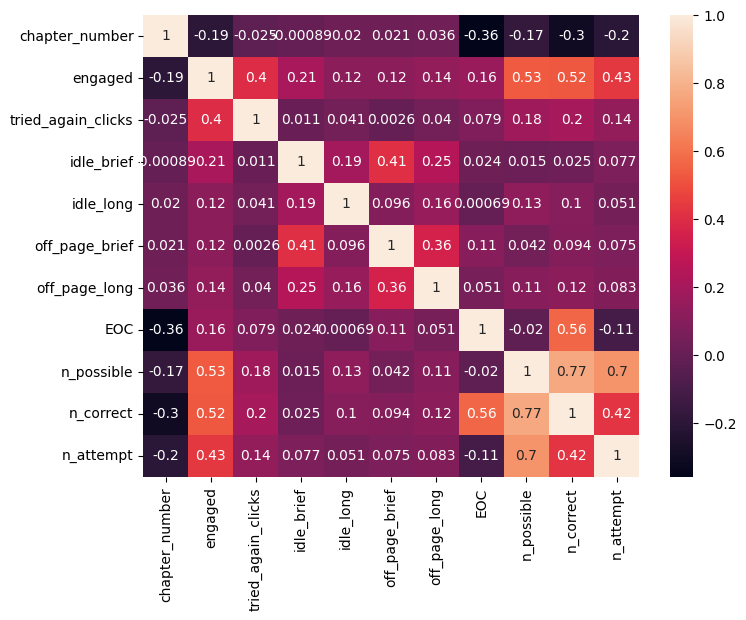

In [105]:
cols_list = merged_clean.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize = (8,6))
sns.heatmap(merged_clean[cols_list].corr(), annot = True)

I preserved the features that appeared to have higher correlation with EOC

In [151]:
# engage_eoc = merged_clean.groupby('student_id').agg({'engaged': 'sum', 'EOC': 'mean', 'was_complete': 'mean', 'tried_again_clicks': 'mean', 'idle_brief': 'mean', 'idle_long': 'mean', 'off_page_brief': 'mean', 'off_page_long': 'mean'})
engage_eoc = merged_clean.groupby('student_id', as_index=False).agg({'engaged': 'sum', 'EOC': 'mean', 'was_complete': 'mean', 'tried_again_clicks': 'mean'})
engage_eoc

,student_id,engaged,EOC,was_complete,tried_again_clicks
0,001824fb-a2fd-431d-aef6-7a1250d97a62,180607618.0,0.742709,0.453698,0.049251
1,041a771b-41cc-4b36-928d-ec321f918db5,59988788.0,0.591916,0.174255,0.000000
2,04347fe5-e55a-4adc-86f2-a156ddfcfc13,184684699.0,0.816617,0.699267,0.252827
3,045d0e87-585c-4126-a2c0-c744effb11b2,80957650.0,0.532648,0.160993,0.075000
4,05588964-8577-4b9f-9a5e-ddb770184d3c,91013684.0,0.535100,0.630189,0.239281
...,...,...,...,...,...
234,fcdfb64b-0dd7-4839-a76d-1bd3d688d5c0,83035503.0,0.768626,0.339728,0.000000
235,fd2a1c41-0bc1-47c6-8ab3-d238a9a648ef,65267880.0,0.496772,0.190072,0.000000
236,fdc4706b-6963-41e4-9a96-ce7b44b2dc46,93200354.0,0.453436,0.126529,0.000000
237,fe5182ec-6732-402e-91f6-a5ddec5107ba,33467180.0,0.725060,0.208727,0.000000


Fit a linear regression model to see whether there are simple relationship between these features and EOC.

R^2 Score: 0.039197265527899705
RMSE: 0.15512242033285317


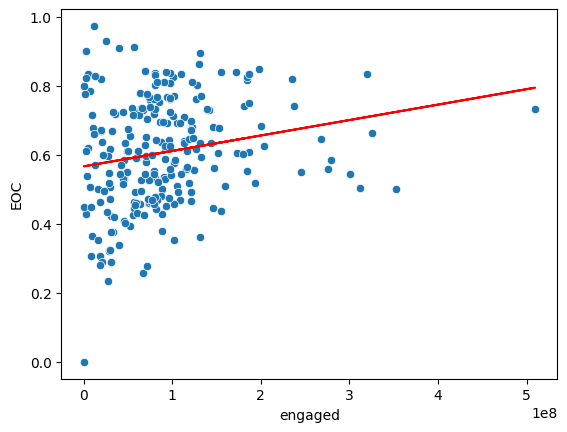

In [109]:
sns.scatterplot(x='engaged', y='EOC', data=engage_eoc)

model = LinearRegression()
model.fit(engage_eoc[['engaged']], engage_eoc['EOC'])
m = model.coef_[0]
b = model.intercept_
plt.plot(engage_eoc['engaged'], m*engage_eoc['engaged'] + b, color='red')

predictions = model.predict(engage_eoc[['engaged']])

# Calculate R^2 score
r2 = r2_score(engage_eoc['EOC'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(engage_eoc['EOC'], predictions))

print(f'R^2 Score: {r2}')
print(f'RMSE: {rmse}')

Apparantly, the linear regression model isn't a very great fit for the data here. Perhaps we can try to do unsupervised learning to learn hidden patterns.

# K-means Cluster

## Harder chapters

In [155]:
engage_eoc['was_complete'] = engage_eoc['was_complete'].astype(float)

In [114]:
col = engage_eoc.select_dtypes(np.number).columns.values
col

array(['engaged', 'EOC', 'was_complete', 'tried_again_clicks'],
      dtype=object)

In [115]:
ABC13 = merged_df[(merged_df['book'] == 'College / Statistics and Data Science (ABC)') & (merged_df['chapter_number'] == 13) | (merged_df['chapter_number'] == 11)]

In [116]:
ABC13.shape

(219, 15)

In [117]:
scaler = StandardScaler()
scaler.fit(ABC13[col])
ABC13_scaled = scaler.transform(ABC13[col])
ABC13_scaled = pd.DataFrame(ABC13_scaled, columns = col)

In [118]:
pca_ABC13 = PCA(n_components=ABC13_scaled.shape[1], random_state=0)
pca_ABC13.fit(ABC13_scaled)
pca_df_ABC13 = pca_ABC13.transform(ABC13_scaled)
pca_df_ABC13 = pd.DataFrame(pca_df_ABC13)

In [119]:
model_ABC13 = KMeans(n_clusters = 2)
model_ABC13.fit(pca_df_ABC13)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

<Axes: xlabel='0', ylabel='1'>

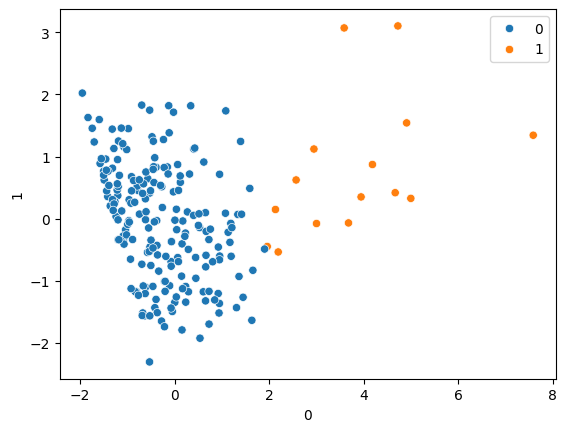

In [120]:
sns.scatterplot(x = pca_df_ABC13.iloc[:,0], y = pca_df_ABC13.iloc[:,1], hue = model_ABC13.predict(pca_df_ABC13))

In [121]:
kmeans_ABC13 = ABC13_scaled.copy()
kmeans_ABC13['labels'] = model_ABC13.labels_
kmeans_ABC13

,engaged,EOC,was_complete,tried_again_clicks,labels
0,0.369274,0.772477,1.213614,-0.265584,0
1,0.051825,-0.608769,-0.412440,-0.265584,0
2,0.725269,1.147850,1.928449,-0.265584,0
3,0.117240,-0.222331,-0.841538,-0.265584,0
4,-0.261911,-0.029111,1.032941,-0.265584,0
...,...,...,...,...,...
214,-0.511739,0.976089,-0.582485,-0.265584,0
215,-0.393906,-0.428903,-1.135131,-0.265584,0
216,-0.601104,-1.137580,-1.135131,-0.265584,0
217,-0.715827,-0.441313,-1.135131,-0.265584,0


In [122]:
ABC13_labeld = ABC13_merge.copy()[col]
ABC13_labeld['labels'] = model_ABC13.labels_
ABC13_labeld

,engaged,EOC,was_complete,tried_again_clicks,labels
0,10808091.0,0.638554,0.5,0.0,0
1,7935012.0,0.367089,0.153846,0.0,0
2,14030032.0,0.712329,0.652174,0.0,0
3,8527048.0,0.443038,0.0625,0.0,0
4,5095533.0,0.481013,0.461538,0.0,0
...,...,...,...,...,...
214,2834458.0,0.678571,0.117647,0.0,0
215,3900910.0,0.402439,0.0,0.0,0
216,2025658.0,0.263158,0.0,0.0,0
217,987351.0,0.400000,0.0,0.0,0


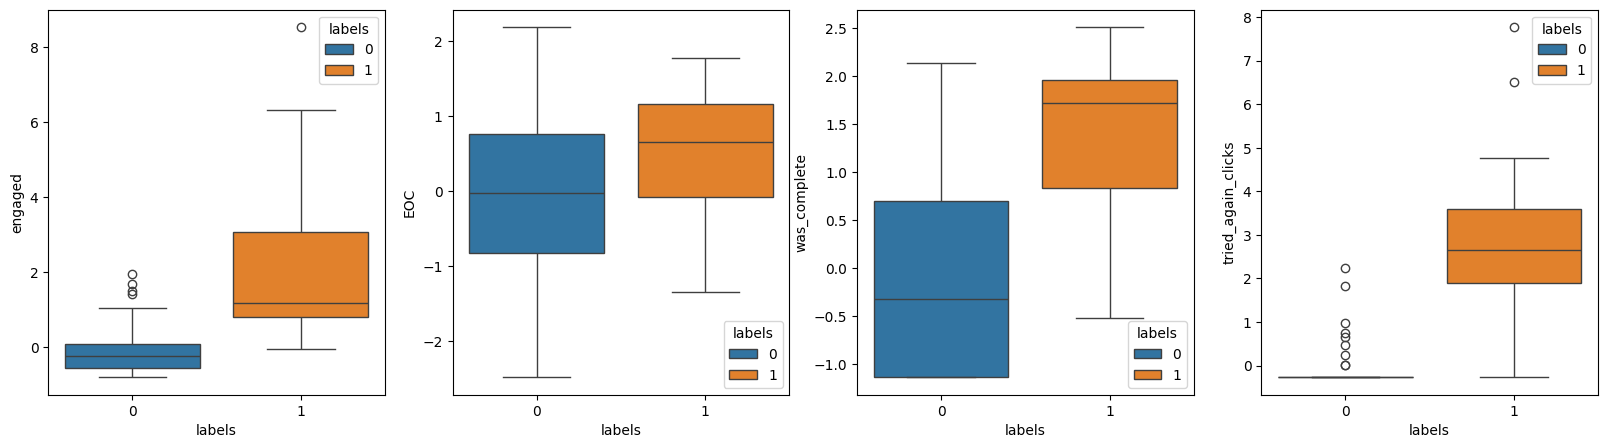

In [124]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))

for j in range(4):
  sns.boxplot(data = kmeans_ABC13, x = 'labels', y = col[j], hue = 'labels', ax = ax[j])

In [125]:
cluster_kmeans = ABC13_labeld.groupby('labels').mean()
cluster_kmeans['count'] = ABC13_labeld.groupby('labels')['EOC'].count().values

In [126]:
cluster_kmeans[col]

,engaged,EOC,was_complete,tried_again_clicks
labels,,,,
0,5.929435e+06,0.479923,0.220174,0.022491
1,2.836278e+07,0.579361,0.533665,1.555326


We can calculate the mean of each column for the two clusters, and see that cluster 0 has 0.1 lower EOC on average than cluster 1. We can also see that cluster 1 is 31% more likely to revisit after completing, retry 1.53 more times, and engage about 2.247 x 10^7 seconds more on average than cluster 0.

Though there might be other influencing factors that are not being observed, we can reasonably suggest that it would be helpful towards students’ EOC by encouraging periodic reviews of completed contents, for example, keep track of contents the student missed, and have them revisit these contents at the end of each chapter, providing incentives or support for retry attempts, and reminding students for low engagement time.

## All chapters

In [55]:
pulse = pd.read_csv('/content/drive/MyDrive/UW/datafest/sample/checkpoints_pulse.csv')

In [56]:
pulse

,book,release,institution_id,class_id,student_id,chapter_number,construct,response
0,College / Statistics and Data Science (ABC),v5.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,10,Cost,NaN
1,College / Statistics and Data Science (ABC),v5.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,11,Cost,NaN
2,College / Statistics and Data Science (ABC),v5.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,12,Cost,NaN
3,College / Statistics and Data Science (ABC),v5.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,2,Cost,2.0
4,College / Statistics and Data Science (ABC),v5.0,04157183-8665-400a-925d-3bbb70ffe45e,afcb6b4e-a0c0-46ce-b38c-c96329c91471,953768c5-32fa-4190-8fee-1da82d8710bc,3,Cost,2.0
...,...,...,...,...,...,...,...,...
11707,High School / Advanced Statistics and Data Sci...,v5.0,fc5f1b1b-2aeb-4e09-93fc-06fdac0d8030,95370fbf-5008-435f-b801-8214285f251b,358dde6e-b5ae-4fa4-898e-05cfff311129,9,Utility Value,NaN
11708,High School / Advanced Statistics and Data Sci...,v5.0,fc5f1b1b-2aeb-4e09-93fc-06fdac0d8030,95370fbf-5008-435f-b801-8214285f251b,358dde6e-b5ae-4fa4-898e-05cfff311129,13,Cost,NaN
11709,High School / Advanced Statistics and Data Sci...,v5.0,fc5f1b1b-2aeb-4e09-93fc-06fdac0d8030,95370fbf-5008-435f-b801-8214285f251b,358dde6e-b5ae-4fa4-898e-05cfff311129,13,Utility Value,NaN
11710,High School / Advanced Statistics and Data Sci...,v5.0,fc5f1b1b-2aeb-4e09-93fc-06fdac0d8030,95370fbf-5008-435f-b801-8214285f251b,358dde6e-b5ae-4fa4-898e-05cfff311129,13,Expectancy,NaN


In [127]:
pulse_pivot = pulse.pivot_table(index=['student_id', 'chapter_number'], columns='construct', values='response', aggfunc='first')

# Create a MultiIndex for all possible combinations of student_id and chapter_number
index = pd.MultiIndex.from_product([pulse['student_id'].unique(), pulse['chapter_number'].unique()], names=['student_id', 'chapter_number'])

# Reindex the DataFrame to include all combinations and fill missing responses with 'na'
pulse_reindexed = pulse_pivot.reindex(index, fill_value=None).reset_index()

In [128]:
pulse_reindexed[pulse_reindexed['student_id'] == '953768c5-32fa-4190-8fee-1da82d8710bc']

construct,student_id,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value
0,953768c5-32fa-4190-8fee-1da82d8710bc,10,NaN,NaN,NaN,NaN
1,953768c5-32fa-4190-8fee-1da82d8710bc,11,NaN,NaN,NaN,NaN
2,953768c5-32fa-4190-8fee-1da82d8710bc,12,NaN,NaN,NaN,NaN
3,953768c5-32fa-4190-8fee-1da82d8710bc,2,2.0,5.0,6.0,6.0
4,953768c5-32fa-4190-8fee-1da82d8710bc,3,2.0,6.0,6.0,6.0
5,953768c5-32fa-4190-8fee-1da82d8710bc,4,NaN,NaN,NaN,NaN
6,953768c5-32fa-4190-8fee-1da82d8710bc,5,2.0,5.0,6.0,6.0
7,953768c5-32fa-4190-8fee-1da82d8710bc,6,2.0,6.0,6.0,6.0
8,953768c5-32fa-4190-8fee-1da82d8710bc,7,NaN,NaN,NaN,NaN
9,953768c5-32fa-4190-8fee-1da82d8710bc,8,2.0,6.0,6.0,6.0


In [129]:
pulse_pivot = pulse.pivot_table(index=['student_id','chapter_number'], columns='construct', values='response', aggfunc='first')

# Reset index to make 'Chapter' a regular column
pulse_pivot.reset_index(inplace=True)
pulse_pivot

construct,student_id,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value
0,001824fb-a2fd-431d-aef6-7a1250d97a62,2,2.0,5.0,5.0,4.0
1,001824fb-a2fd-431d-aef6-7a1250d97a62,3,4.0,4.0,4.0,4.0
2,001824fb-a2fd-431d-aef6-7a1250d97a62,4,4.0,4.0,4.0,4.0
3,001824fb-a2fd-431d-aef6-7a1250d97a62,5,4.0,4.0,4.0,4.0
4,001824fb-a2fd-431d-aef6-7a1250d97a62,6,5.0,3.0,4.0,3.0
...,...,...,...,...,...,...
1708,fe5182ec-6732-402e-91f6-a5ddec5107ba,9,4.0,4.0,4.0,4.0
1709,fef083e8-7167-4f42-82d5-d2e893aa408a,7,5.0,5.0,5.0,5.0
1710,fef083e8-7167-4f42-82d5-d2e893aa408a,8,4.0,4.0,4.0,4.0
1711,fef083e8-7167-4f42-82d5-d2e893aa408a,9,2.0,4.0,4.0,4.0


In [130]:
pulse_reindexed.isna().sum()

construct
student_id            0
chapter_number        0
Cost               1169
Expectancy         1146
Intrinsic Value    1200
Utility Value      1156
dtype: int64

In [131]:
pulse_filtered = pulse_reindexed.dropna(subset=['Cost', 'Expectancy', 'Intrinsic Value', 'Utility Value'], how='all')

In [132]:
pulse_filtered.isna().sum()

construct
student_id          0
chapter_number      0
Cost               26
Expectancy          3
Intrinsic Value    57
Utility Value      13
dtype: int64

In [134]:
pulse_fill = pulse_filtered.drop('student_id', axis = 1).fillna(pulse_filtered.drop('student_id', axis = 1).mean())

In [136]:
pulse_fill['student_id'] = pulse_filtered['student_id']

In [145]:
pulse_group = pulse_fill.groupby('student_id', as_index = False).agg({'Cost': 'mean', 'Expectancy': 'mean', 'Intrinsic Value': 'mean', 'Utility Value': 'mean'})

In [146]:
pulse_fill.isna().sum()

construct
chapter_number     0
Cost               0
Expectancy         0
Intrinsic Value    0
Utility Value      0
student_id         0
dtype: int64

In [147]:
pulse_group

construct,student_id,Cost,Expectancy,Intrinsic Value,Utility Value
0,001824fb-a2fd-431d-aef6-7a1250d97a62,4.181818,3.727273,4.636364,4.090909
1,045d0e87-585c-4126-a2c0-c744effb11b2,1.636364,4.000000,6.000000,5.818182
2,08929fc3-2331-4c9a-bd15-68147ea87d01,3.727273,3.909091,4.181818,4.272727
3,0a1c6dbe-74fc-4984-9721-f301535753a4,3.500000,4.125000,4.625000,4.750000
4,0f122889-830d-40c1-a6f8-f432cb327190,2.272727,4.363636,3.818182,4.090909
...,...,...,...,...,...
187,fcdfb64b-0dd7-4839-a76d-1bd3d688d5c0,3.500000,3.750000,4.166667,4.583333
188,fd2a1c41-0bc1-47c6-8ab3-d238a9a648ef,3.000000,4.090909,4.090909,4.090909
189,fdc4706b-6963-41e4-9a96-ce7b44b2dc46,2.900000,4.100000,4.100000,4.100000
190,fe5182ec-6732-402e-91f6-a5ddec5107ba,4.285714,2.857143,3.857143,3.857143


In [157]:
pulse_engage = pd.merge(engage_eoc, pulse_group, on='student_id')

In [158]:
pulse_engage

,student_id,engaged,EOC,was_complete,tried_again_clicks,Cost,Expectancy,Intrinsic Value,Utility Value
0,001824fb-a2fd-431d-aef6-7a1250d97a62,180607618.0,0.742709,0.453698,0.049251,4.181818,3.727273,4.636364,4.090909
1,045d0e87-585c-4126-a2c0-c744effb11b2,80957650.0,0.532648,0.160993,0.075000,1.636364,4.000000,6.000000,5.818182
2,08929fc3-2331-4c9a-bd15-68147ea87d01,88827454.0,0.501385,0.089290,0.000000,3.727273,3.909091,4.181818,4.272727
3,0a1c6dbe-74fc-4984-9721-f301535753a4,63655906.0,0.456730,0.141030,0.000000,3.500000,4.125000,4.625000,4.750000
4,0f122889-830d-40c1-a6f8-f432cb327190,184159827.0,0.825628,0.383807,0.131768,2.272727,4.363636,3.818182,4.090909
...,...,...,...,...,...,...,...,...,...
187,fcdfb64b-0dd7-4839-a76d-1bd3d688d5c0,83035503.0,0.768626,0.339728,0.000000,3.500000,3.750000,4.166667,4.583333
188,fd2a1c41-0bc1-47c6-8ab3-d238a9a648ef,65267880.0,0.496772,0.190072,0.000000,3.000000,4.090909,4.090909,4.090909
189,fdc4706b-6963-41e4-9a96-ce7b44b2dc46,93200354.0,0.453436,0.126529,0.000000,2.900000,4.100000,4.100000,4.100000
190,fe5182ec-6732-402e-91f6-a5ddec5107ba,33467180.0,0.725060,0.208727,0.000000,4.285714,2.857143,3.857143,3.857143


In [180]:
num_col = pulse_engage.select_dtypes(np.number).columns.values
num_col

array(['engaged', 'EOC', 'was_complete', 'tried_again_clicks', 'Cost',
       'Expectancy', 'Intrinsic Value', 'Utility Value'], dtype=object)

In [181]:
scaler = StandardScaler()
scaler.fit(pulse_engage[num_col])
scaled_df = scaler.transform(pulse_engage[num_col])
scaled_df = pd.DataFrame(scaled_df, columns = num_col)

In [161]:
# PCA
pca = PCA(n_components=scaled_df.shape[1], random_state=0)
pca.fit(scaled_df)
pca_df = pca.transform(scaled_df)

In [162]:
pca_df = pd.DataFrame(pca_df)
pca_df

,0,1,2,3,4,5,6,7
0,-0.252812,1.788479,0.191711,0.971543,0.348182,-1.557078,0.322410,0.388349
1,-1.839453,-1.360270,-0.104340,-1.066912,0.314306,0.698561,1.537053,0.117750
2,0.833499,-0.758845,0.937268,0.254859,0.684255,0.264044,-0.009949,-0.195124
3,0.196303,-1.086243,1.013535,-0.197091,0.134236,0.133491,0.138861,-0.188778
4,-0.601919,1.692431,-1.560280,0.326009,0.929666,-0.243281,-0.418627,-0.093614
...,...,...,...,...,...,...,...,...
187,0.103873,0.370444,-0.564340,0.898557,-0.400643,-0.637744,0.284656,-0.281855
188,0.700833,-0.586966,0.209306,-0.435122,0.150156,0.219452,-0.277247,-0.027795
189,0.684380,-0.651775,0.436993,-0.583605,0.784124,0.425433,-0.245957,-0.081012
190,1.787642,-0.132311,0.051753,1.413006,-0.606815,-0.184046,0.619509,-0.059981


In [163]:
pca_df.var() / sum(pca_df.var())

0    0.354431
1    0.203371
2    0.136075
3    0.105670
4    0.075637
5    0.072996
6    0.037337
7    0.014483
dtype: float64

In [166]:
sum(pca.explained_variance_ratio_[:6])

0.9481802303287997

95% of variance is explained by 6 features.

In [167]:
model = KMeans(n_clusters = 4)
model.fit(pca_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

I have also tried different number of clusters, but in the end, I think 4 clusters best separates the different groups.

<Axes: xlabel='0', ylabel='1'>

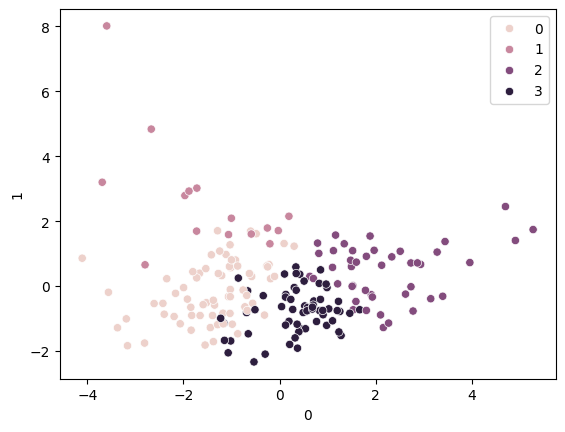

In [168]:
sns.scatterplot(x = pca_df.iloc[:,0], y = pca_df.iloc[:,1], hue = model.predict(pca_df))

In [175]:
from scipy.spatial.distance import cdist
clusters_ = range(1, 5)
distortion = []

for k in clusters_:

  model = KMeans(n_clusters = k)
  model.fit(pca_df)
  Y = model.predict(pca_df)

  distortion.append(
  sum(np.min(cdist(pca_df, model.cluster_centers_), axis = 1))/pca_df.shape[0]
  )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [176]:
df_kmeans = scaled_df.copy()
df_kmeans['labels'] = model.labels_
df_kmeans

,engaged,EOC,was_complete,tried_again_clicks,Cost,Expectancy,Intrinsic Value,Utility Value,labels
0,1.552486,0.893227,1.407198,-0.118200,1.213684,-0.410210,0.296945,-0.334637,0
1,-0.108948,-0.450460,-0.755188,-0.027686,-1.588006,-0.114199,1.908480,1.543802,0
2,0.022263,-0.650444,-1.284897,-0.291326,0.713383,-0.212870,-0.240234,-0.136906,3
3,-0.397415,-0.936084,-0.902662,-0.291326,0.463232,0.021472,0.283515,0.382136,3
4,1.611711,1.423637,0.890867,0.171865,-0.887583,0.280482,-0.669977,-0.334637,0
...,...,...,...,...,...,...,...,...,...
187,-0.074305,1.059014,0.565232,-0.291326,0.463232,-0.385543,-0.258140,0.200883,3
188,-0.370539,-0.679950,-0.540367,-0.291326,-0.087100,-0.015529,-0.347670,-0.334637,3
189,0.095171,-0.957157,-1.009792,-0.291326,-0.197167,-0.005662,-0.336926,-0.324750,3
190,-0.900742,0.780333,-0.402547,-0.291326,1.328039,-1.354626,-0.623933,-0.588861,3


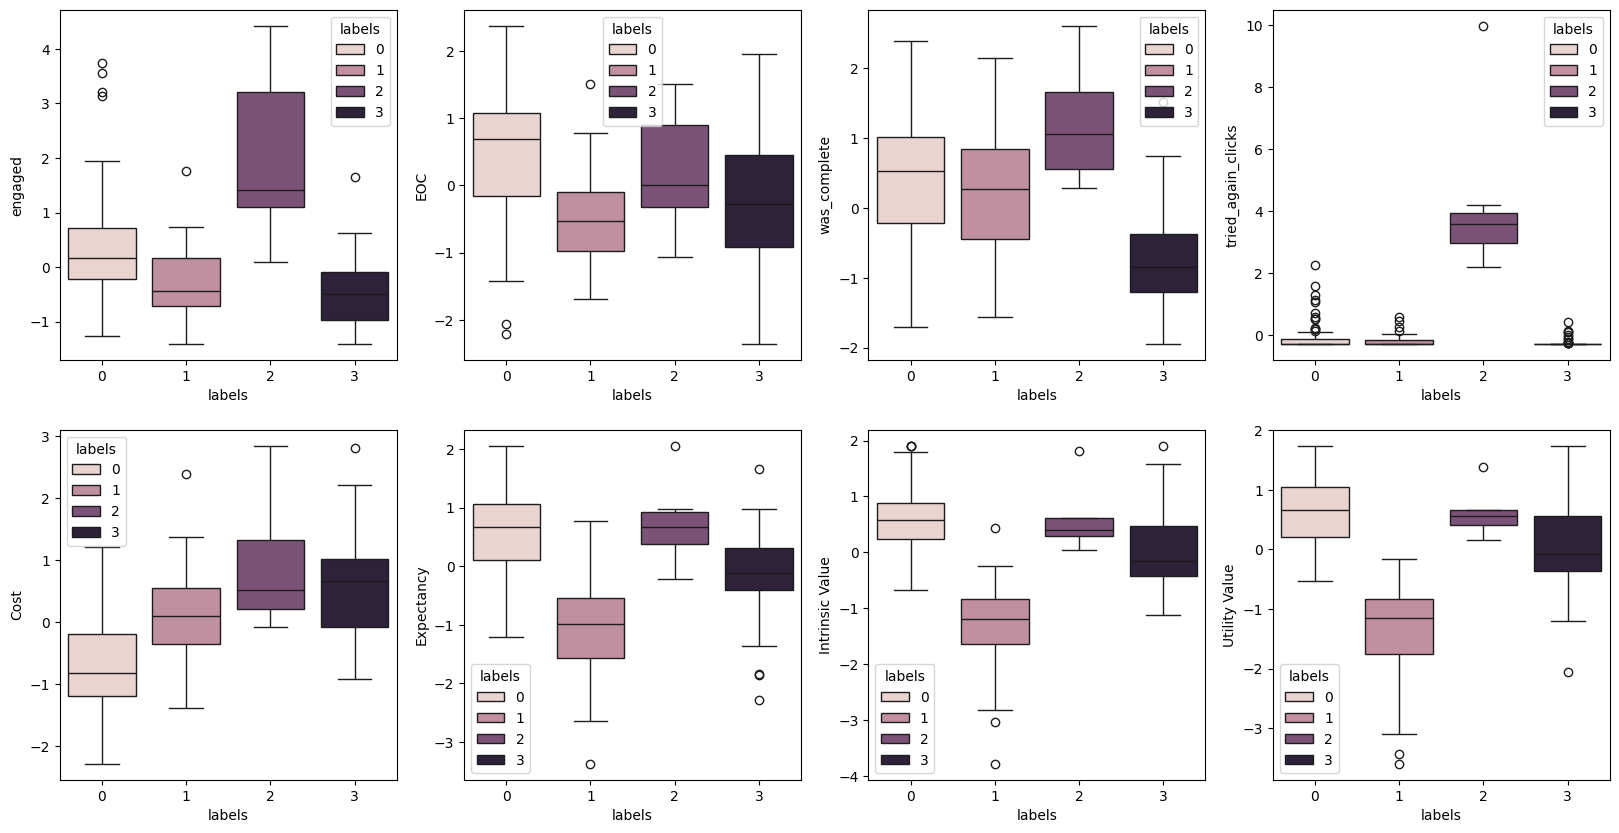

In [177]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))

for i in range(2):
  for j in range(4):
    sns.boxplot(data = df_kmeans, x = 'labels', y = num_col[4*i+j], hue = 'labels', ax = ax[i][j])

This plot here is generated after reorganizing the notebook and reruning the cells, so somehow it ended up being a slight different version than the one submitted for Datafest.

Please check our report to get better understanding of why we made our recommendations.

# Recommendations

Encourage periodic reviews of completed contents, for example, keep track of contents the student missed, and have them revisit these contents at the end of each chapter

* Students with higher EOC are 31% more likely to revisit after completing on average

Provide incentives or support for retry attempts

* Students with higher EOC retry 1.53 times more on average than those who have lower EOC

Remind students for low engagement time
* Students with higher EOC engage about 2.247 x 10^7 seconds more on average
